# Time Series Analysis of Walmart Sales (2010 - 2012)

Perform time series analysis of Walmart Sales in the U.S. from January 2010 to October 2012. The data used in the analysis are prepared by the [data wrangling program](https://github.com/nphan20181/walmart_sales/blob/master/00_walmart_data_wrangling.ipynb).

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, FactorRange

sns.set()
output_notebook()

mpl.rcParams['axes.titlesize'] = 17    # font size for plot title
mpl.rcParams['axes.labelsize'] = 14    # font size for x-axis' and y-axis' label

Loading BokehJS ...

In [2]:
# load data
weekly_sales = pd.read_pickle('out/weekly_sales.pkl')
store_sales = pd.read_pickle('out/store_sales.pkl')

## Original Time Series & General Trend

In [3]:
def assign_holiday(date):
    global holidays
    
    # assign holiday name to specific date
    for col_name in holidays.columns:
        isHoliday = holidays[col_name] == date
        if len( holidays[isHoliday]) > 0:
            return col_name
    return ''

In [4]:
'''Create a data frame that contains holiday sales'''

# create a data frame of holidays
holidays = pd.DataFrame(dict({'Super Bowl': ['2010-02-12', '2011-02-11', '2012-02-10', '2012-02-08'],
                 'Labor Day': ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
                 'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'],
                 'Christmas': ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']}))

# convert date string to datetime object
for col_name in holidays.columns:
    holidays[col_name] = pd.to_datetime(holidays[col_name])

# create a data frame of holiday sales
pd.options.mode.chained_assignment = None
holiday_sales = weekly_sales[weekly_sales.IsHoliday == True]
holiday_sales['Holiday'] = holiday_sales['Date'].apply(assign_holiday)
holiday_sales.head()

,Date,IsHoliday,Week,Month,Quarter,Year,Weekly Sales (Million),Holiday
5,2010-02-12,True,6,2,1,2010,48.336678,Super Bowl
35,2010-09-10,True,36,9,3,2010,45.634398,Labor Day
46,2010-11-26,True,47,11,4,2010,65.821003,Thanksgiving
51,2010-12-31,True,52,12,4,2010,40.432519,Christmas
57,2011-02-11,True,6,2,1,2011,47.336193,Super Bowl


In [5]:
'''General Trend of the whole sales data'''
from sklearn.linear_model import LinearRegression

trend_model = LinearRegression(normalize=True, fit_intercept=True)
trend_model.fit(np.array(weekly_sales.index).reshape((-1,1)), weekly_sales['Weekly Sales (Million)'])
predicts = trend_model.predict(np.array(weekly_sales.index).reshape((-1,1)))
weekly_sales['Residuals'] = weekly_sales['Weekly Sales (Million)'] - predicts

print('Trend model:')
print('\tcoefficient: {}'.format(trend_model.coef_[0]))
print('\tintercept: {}'.format(trend_model.intercept_))

Trend model:
	coefficient: 0.009896419849469944
	intercept: 46.2402702377574


In [6]:
''' Plot weekly sales and mark the holiday week with circle '''

# prepare data source
source = ColumnDataSource(data=weekly_sales)      

# prepare hover text
hover = HoverTool(tooltips=[("Week", "@Week"),
                            ("Month", "@Month"),
                            ("Year", "@Year"),
                            ("Sales", "$y")])

# create figure
p = figure(x_axis_type="datetime", title="Walmart's Weekly Sales in U.S. (Jan 2010 to Oct 2012)", 
           plot_height=400, plot_width=800, tools=[hover])
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Weekly Sales (Million USD)'

# draw line plot
p.line(x='Date',y='Weekly Sales (Million)', source=source)

# draw trend line
p.line(x=weekly_sales['Date'], y=predicts, color='gray', line_dash='dashed',
       legend_label='y = {0} + {1}x'.format(round(trend_model.intercept_,2), round(trend_model.coef_[0],5)))

# draw circle plot to indicate the holiday in certain week
holiday_colors = ['orange', 'red', 'green', 'magenta']
for index, holiday in enumerate(['Labor Day', 'Super Bowl', 'Thanksgiving', 'Christmas']):
    data = holiday_sales[holiday_sales['Holiday'] == holiday]
    source1 = ColumnDataSource(data=data)
    p.circle(x='Date', y='Weekly Sales (Million)', source=source1, size=7, color=holiday_colors[index],
        legend_label=holiday)

p.legend.location = "top_right"
p.legend.click_policy="hide"

# save to html file
output_file('out/walmart_ts.htm', mode='inline')

show(p)  # show plot

In [7]:
# plot residuals of trend model

# create figure
p = figure(x_axis_type="datetime", title="Residuals of Trend Model for Weekly Sales (1/2010 - 10/2012)", 
           plot_height=300, plot_width=800)

# draw line plot
p.line(x=weekly_sales['Date'], y=weekly_sales['Residuals'])

p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Weekly Sales (Million USD)'

output_file('out/walmart_ts_resids.htm', mode='inline')
show(p)

## Seasonality

In [8]:
store_sales.head()

,Store,Date,Store Weekly Sales (Thousand),Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Week,Month,Year,Quarter,MarkDown
0,1,2010-02-05,1643.69090,42.31,2.572,211.096358,8.106,False,5,2,2010,1,NaN
1,1,2010-02-12,1641.95744,38.51,2.548,211.242170,8.106,True,6,2,2010,1,NaN
2,1,2010-02-19,1611.96817,39.93,2.514,211.289143,8.106,False,7,2,2010,1,NaN
3,1,2010-02-26,1409.72759,46.63,2.561,211.319643,8.106,False,8,2,2010,1,NaN
4,1,2010-03-05,1554.80668,46.50,2.625,211.350143,8.106,False,9,3,2010,1,NaN


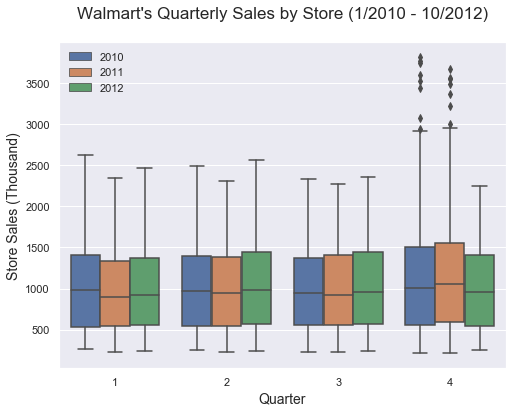

In [9]:
'''Create box plot of Quarterly Sales'''

fig, ax = plt.subplots(figsize=(8, 6))
_ = sns.boxplot('Quarter', 'Store Weekly Sales (Thousand)', data=store_sales, hue='Year', ax=ax)
plt.legend(loc='upper left', frameon=False)
plt.ylabel('Store Sales (Thousand)')
plt.title('Walmart\'s Quarterly Sales by Store (1/2010 - 10/2012)\n')
plt.show()

In [10]:
# compute monthly mean and standard deviation of residuals
seasonal_sales = weekly_sales.groupby(by=['Year', 'Month'])['Residuals'].aggregate([np.mean, np.std])
seasonal_sales.columns = ['Monthly Mean', 'Monthly Standard Deviation']
seasonal_sales.head()

Monthly Mean  Monthly Standard Deviation
Year Month                                          
2010 1         -4.680310                    1.723875
     2          1.288545                    2.515658
     3         -0.854336                    1.194226
     4         -0.096347                    2.687416
     5          0.254380                    1.709333

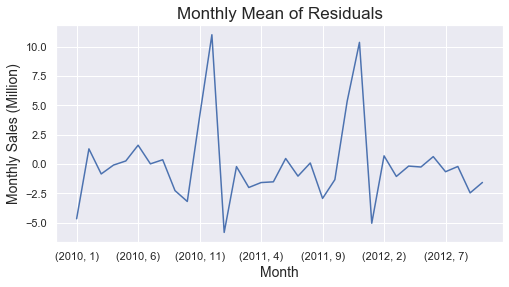

In [11]:
# plot monthly mean of residuals
fig, ax = plt.subplots(figsize=(8, 4))
seasonal_sales['Monthly Mean'].plot()
plt.xlabel('Month')
plt.ylabel('Monthly Sales (Million)')
plt.title('Monthly Mean of Residuals')
plt.show()

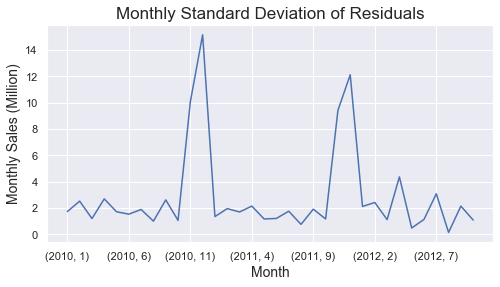

In [12]:
# plot monthly standard deviation of residuals
fig, ax = plt.subplots(figsize=(8, 4))
seasonal_sales['Monthly Standard Deviation'].plot()
plt.xlabel('Month', size=14)
plt.ylabel('Monthly Sales (Million)')
plt.title('Monthly Standard Deviation of Residuals')
plt.show()

## Stationarity

In [13]:
# code obtained from https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
def test_stationarity(timeseries):
    '''
    Plot original time series, 52-weeks rolling mean & standard deviation.
    Return Dickey-Fuller test result that indicate whether time series is stationary or not.
    
    Parameter:
    - timeseries: time series data
    '''

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52).mean()
    rolstd = timeseries.rolling(window=52).std()

    #Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(14, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best', frameon=False)
    plt.xlabel('Index', size=14)
    plt.ylabel('Weekly Sales (Million USD)')
    plt.title('52-Weeks Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

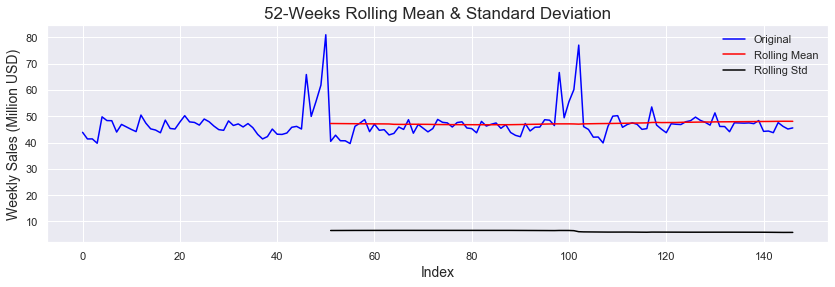

Results of Dickey-Fuller Test:
Test Statistic                -5.977907e+00
p-value                        1.868362e-07
#Lags Used                     4.000000e+00
Number of Observations Used    1.420000e+02
Critical Value (1%)           -3.477262e+00
Critical Value (5%)           -2.882118e+00
Critical Value (10%)          -2.577743e+00
dtype: float64


In [14]:
test_stationarity(weekly_sales['Weekly Sales (Million)'])

Time series is stationary because the p-value is less than 0.05. Thus no differencing is needed.

## Time Series Decomposition

In [15]:
decomposition = seasonal_decompose(weekly_sales['Weekly Sales (Million)'], period=52, model='additive')
original = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

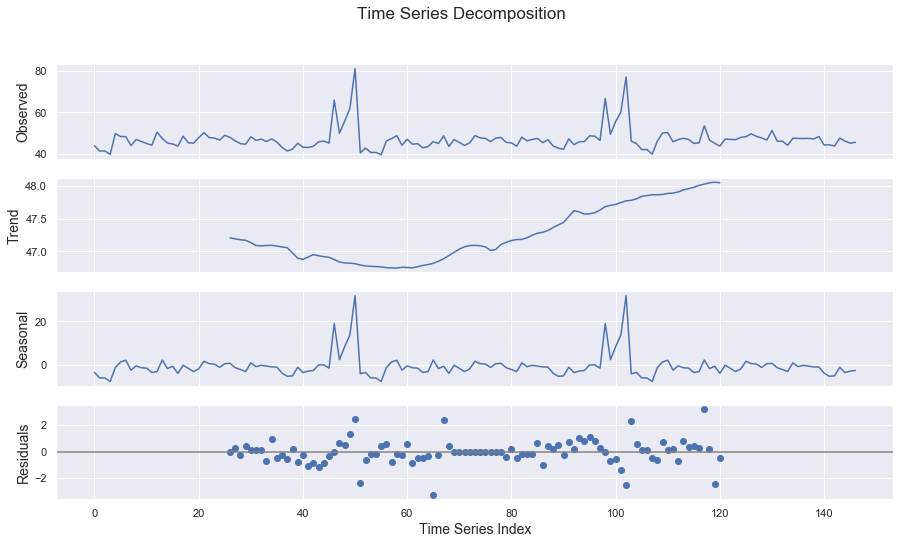

In [16]:
'''Plot time series decomposition'''

# create figure
fig, ax = plt.subplots(figsize=(15, 8), nrows=4, sharex=True)

ax[0].plot(original)
ax[1].plot(trend)
ax[2].plot(seasonal)
ax[3].scatter(x=residuals.index, y=residuals)
ax[3].axhline(np.mean(residuals), color='gray')

ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residuals')

plt.xlabel('Time Series Index')
plt.suptitle('Time Series Decomposition', size=17)
plt.show()